In [1]:
import pandas as pd
import numpy as np
import sys
import yaml

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm
from torch.optim import AdamW

from transformers import get_linear_schedule_with_warmup, RobertaModel, RobertaConfig, RobertaTokenizer

from PolymerSmilesTokenization import PolymerSmilesTokenizer
from dataset import Downstream_Dataset, DataAugmentation

from sklearn.metrics import r2_score

from copy import deepcopy

import pickle

from sklearn.preprocessing import StandardScaler

/jet/home/entaoy/.conda/envs/TransPoly/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DownstreamRegression(nn.Module):
    def __init__(self, drop_rate=0.1):
        super(DownstreamRegression, self).__init__()
        self.PretrainedModel = deepcopy(PretrainedModel)
        self.PretrainedModel.resize_token_embeddings(len(tokenizer))

        self.Regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(self.PretrainedModel.config.hidden_size, self.PretrainedModel.config.hidden_size),
            nn.SiLU(),
            nn.Linear(self.PretrainedModel.config.hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.PretrainedModel(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.last_hidden_state[:, 0, :]
        output = self.Regressor(logits)
        return output

In [3]:
import matplotlib.pyplot as plt

In [4]:
finetune_config = yaml.load(open("./config_finetune.yaml", "r"), Loader=yaml.FullLoader)

In [5]:
finetune_config

{'CV_flag': False,
 'add_vocab_flag': False,
 'LLRD_flag': False,
 'aug_flag': False,
 'aug_special_flag': False,
 'model_indicator': 'pretrain',
 'aug_indicator': None,
 'vocab_sup_file': None,
 'train_file': 'Egb_train.csv',
 'test_file': 'Egb_test.csv',
 'model_path': '../TransPolymer/ckpt/pretrain.pt',
 'save_path': 'ckpt/Egb_train.pt',
 'best_model_path': 'ckpt/Egb_best_model.pt',
 'num_of_tasks': 1,
 'k': 5,
 'blocksize': 512,
 'batch_size': 32,
 'num_epochs': 20,
 'warmup_ratio': 0.1,
 'drop_rate': 0.1,
 'lr_rate': 0.0001,
 'lr_rate_reg': 5e-05,
 'weight_decay': 1e-05,
 'hidden_dropout_prob': 0.1,
 'attention_probs_dropout_prob': 0.1,
 'tolerance': 5,
 'num_workers': 1}

In [6]:
PretrainedModel = RobertaModel.from_pretrained(finetune_config['model_path'])
PretrainedModel.config.hidden_dropout_prob = finetune_config['hidden_dropout_prob']
PretrainedModel.config.attention_probs_dropout_prob = finetune_config['attention_probs_dropout_prob']

tokenizer = PolymerSmilesTokenizer.from_pretrained("roberta-base", max_len=finetune_config['blocksize'])

Some weights of the model checkpoint at ../TransPolymer/ckpt/pretrain.pt were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../TransPolymer/ckpt/pretrain.pt and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

In [7]:
if finetune_config['add_vocab_flag']:
    vocab_sup = pd.read_csv(finetune_config['vocab_sup_file'], header=None).values.flatten().tolist()
    tokenizer.add_tokens(vocab_sup)
    
finetune_config['num_workers'] = 1
max_token_len = finetune_config['blocksize']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
checkpoint = torch.load(finetune_config['best_model_path'])
BestModel = DownstreamRegression(drop_rate=finetune_config['drop_rate']).to(device)
BestModel.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [9]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = embeddings
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'embedding': self.embeddings[idx],
            'target': self.targets[idx]
        }

In [10]:
with open('train_embedding_dataset.pkl', 'rb') as file:
    train_embedding_dataset = pickle.load(file)

with open('test_embedding_dataset.pkl', 'rb') as file:
    test_embedding_dataset = pickle.load(file)

In [12]:
len(train_embedding_dataset), len(test_embedding_dataset)

(448, 113)

In [13]:
train_embedding_df = pd.read_csv('./train_embedding_df.csv')
test_embedding_df = pd.read_csv('./test_embedding_df.csv')
train_embedding_df.shape, test_embedding_df.shape

((448, 769), (113, 769))

In [29]:
len(np.where(train_embedding_dataset[0]['embedding'] - train_embedding_df.iloc[0].values[:-1] < 0.001)[0])

768

Therefore, we confirmed that the train_embedding_df is same as train_embedding_dataset.

In [11]:
train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=32, shuffle=True)
test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=32, shuffle=False)

In [12]:
def train_regressor_save_loss_r2(MLP_regressor1, train_embedding_loader, test_embedding_loader, criterion, num_epochs):
        
    train_loss_traj = []
    test_loss_traj = []    

    for epoch in range(num_epochs):
        MLP_regressor1.train()
        for batch in train_embedding_loader:
            inputs, targets = batch['embedding'], batch['target']
            output1 = MLP_regressor1(inputs).squeeze()
            target1 = targets
            loss = criterion(output1.float().squeeze(), target1.float().squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        all_train_preds = []
        all_train_targets = []
        all_test_preds = []
        all_test_targets = []

        MLP_regressor1.eval()
        train_loss = 0
        test_loss = 0
        with torch.no_grad():
            for batch in train_embedding_loader:
                inputs, targets = batch['embedding'], batch['target']
                output1 = MLP_regressor1(inputs).squeeze()
                target1 = targets
                loss = criterion(output1.float().squeeze(), target1.float().squeeze())
                train_loss += loss.item() * inputs.size(0)

                all_train_preds.extend(output1.cpu().numpy())
                all_train_targets.extend(target1.cpu().numpy())

            all_train_preds = np.array(all_train_preds).reshape(-1)
            all_train_targets = np.array(all_train_targets).reshape(-1)

            train_loss = train_loss / len(all_train_preds)
            train_loss_traj.append(train_loss)
            
            r2_train_task1 = r2_score(all_train_targets, all_train_preds)

            for batch in test_embedding_loader:
                inputs, targets = batch['embedding'], batch['target']
                output1 = MLP_regressor1(inputs).squeeze()
                target1 = targets
                loss = criterion(output1.float().squeeze(), target1.float().squeeze())
                test_loss += loss.item() * inputs.size(0)

                all_test_preds.extend(output1.cpu().numpy())
                all_test_targets.extend(target1.cpu().numpy())

            all_test_preds = np.array(all_test_preds).reshape(-1)
            all_test_targets = np.array(all_test_targets).reshape(-1)

            test_loss = test_loss / len(all_test_preds)
            test_loss_traj.append(test_loss)
            r2_test_task1 = r2_score(all_test_targets, all_test_preds)                

        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}: Train loss is {train_loss:.4f}, test loss is {test_loss:.4f}')
            print(f'        : Task1 train R2 is {r2_train_task1:.4f}, Task1 test R2 is {r2_test_task1:.4f}') 
        
    return train_loss_traj, test_loss_traj, test_loss, r2_test_task1

In [13]:
def train_regressor(MLP_regressor1, train_embedding_loader, test_embedding_loader, criterion, num_epochs):
        
    train_loss_traj = []
    test_loss_traj = []    

    for epoch in range(num_epochs):
        MLP_regressor1.train()
        for batch in train_embedding_loader:
            inputs, targets = batch['embedding'], batch['target']
            output1 = MLP_regressor1(inputs).squeeze()
            target1 = targets
            loss = criterion(output1.float().squeeze(), target1.float().squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        all_train_preds = []
        all_train_targets = []
        all_test_preds = []
        all_test_targets = []

        MLP_regressor1.eval()
        train_loss = 0
        test_loss = 0
        with torch.no_grad():
            for batch in train_embedding_loader:
                inputs, targets = batch['embedding'], batch['target']
                output1 = MLP_regressor1(inputs).squeeze()
                target1 = targets
                loss = criterion(output1.float().squeeze(), target1.float().squeeze())
                train_loss += loss.item() * inputs.size(0)

                all_train_preds.extend(output1.cpu().numpy())
                all_train_targets.extend(target1.cpu().numpy())

            all_train_preds = np.array(all_train_preds).reshape(-1)
            all_train_targets = np.array(all_train_targets).reshape(-1)

            train_loss = train_loss / len(all_train_preds)
            train_loss_traj.append(train_loss)
            
            r2_train_task1 = r2_score(all_train_targets, all_train_preds)

            for batch in test_embedding_loader:
                inputs, targets = batch['embedding'], batch['target']
                output1 = MLP_regressor1(inputs).squeeze()
                target1 = targets
                loss = criterion(output1.float().squeeze(), target1.float().squeeze())
                test_loss += loss.item() * inputs.size(0)

                all_test_preds.extend(output1.cpu().numpy())
                all_test_targets.extend(target1.cpu().numpy())

            all_test_preds = np.array(all_test_preds).reshape(-1)
            all_test_targets = np.array(all_test_targets).reshape(-1)

            test_loss = test_loss / len(all_test_preds)
            test_loss_traj.append(test_loss)
            r2_test_task1 = r2_score(all_test_targets, all_test_preds)                

        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}: Train loss is {train_loss:.4f}, test loss is {test_loss:.4f}')
            print(f'        : Task1 train R2 is {r2_train_task1:.4f}, Task1 test R2 is {r2_test_task1:.4f}') 
        
    return train_loss_traj, test_loss_traj

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## W=2

In [15]:
width = 2
MLP_regressor_scratch = nn.Sequential(nn.Linear(768, width), nn.SiLU(), nn.Linear(width, 1))

In [16]:
train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=32, shuffle=True)
test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=32, shuffle=False)

In [17]:
learning_rate = 5e-4
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)
num_epochs = 501

MLP_regressor_scratch.apply(init_weights)
MLP_regressor_scratch.float()

Sequential(
  (0): Linear(in_features=768, out_features=2, bias=True)
  (1): SiLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [97]:
train_loss_traj, test_loss_traj = train_regressor(MLP_regressor_scratch, train_embedding_loader, test_embedding_loader, criterion, num_epochs)

Epoch 1: Train loss is 0.7143, test loss is 0.8543
        : Task1 train R2 is 0.2857, Task1 test R2 is 0.2690
Epoch 101: Train loss is 0.1705, test loss is 0.2444
        : Task1 train R2 is 0.8295, Task1 test R2 is 0.7909
Epoch 201: Train loss is 0.0956, test loss is 0.1833
        : Task1 train R2 is 0.9044, Task1 test R2 is 0.8432
Epoch 301: Train loss is 0.0626, test loss is 0.1534
        : Task1 train R2 is 0.9374, Task1 test R2 is 0.8687
Epoch 401: Train loss is 0.0462, test loss is 0.1374
        : Task1 train R2 is 0.9538, Task1 test R2 is 0.8824
Epoch 501: Train loss is 0.0367, test loss is 0.1276
        : Task1 train R2 is 0.9633, Task1 test R2 is 0.8908


In [98]:
train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=32, shuffle=True)
test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=32, shuffle=False)

hyper_test_sum = []
lr_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

for i in range(len(lr_list)):
    learning_rate = lr_list[i]
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)
    num_epochs = 501

    MLP_regressor_scratch.apply(init_weights)
    MLP_regressor_scratch.float()
    
    train_loss_traj, test_loss_traj, test_loss, r2_test_task1 = train_regressor_save_loss_r2(MLP_regressor_scratch, train_embedding_loader, test_embedding_loader, criterion, num_epochs)
    
    hyper_test_sum.append([test_loss, r2_test_task1])
    
for i in range(len(lr_list)):
    print(f'lr is {lr_list[i]}, test loss is {hyper_test_sum[i][0]:.4f}, r2 is {hyper_test_sum[i][1]:.4f} ')

Epoch 1: Train loss is 1.4534, test loss is 1.4886
        : Task1 train R2 is -0.4534, Task1 test R2 is -0.2736
Epoch 101: Train loss is 0.3478, test loss is 0.5394
        : Task1 train R2 is 0.6522, Task1 test R2 is 0.5385
Epoch 201: Train loss is 0.2910, test loss is 0.4636
        : Task1 train R2 is 0.7090, Task1 test R2 is 0.6033
Epoch 301: Train loss is 0.2549, test loss is 0.4161
        : Task1 train R2 is 0.7451, Task1 test R2 is 0.6440
Epoch 401: Train loss is 0.2279, test loss is 0.3816
        : Task1 train R2 is 0.7721, Task1 test R2 is 0.6735
Epoch 501: Train loss is 0.2063, test loss is 0.3548
        : Task1 train R2 is 0.7937, Task1 test R2 is 0.6964
Epoch 1: Train loss is 0.7973, test loss is 0.7803
        : Task1 train R2 is 0.2027, Task1 test R2 is 0.3324
Epoch 101: Train loss is 0.0636, test loss is 0.1694
        : Task1 train R2 is 0.9364, Task1 test R2 is 0.8551
Epoch 201: Train loss is 0.0366, test loss is 0.1502
        : Task1 train R2 is 0.9634, Task1 tes

Epoch 1: Train loss is 0.5337, test loss is 0.6508
        : Task1 train R2 is 0.4663, Task1 test R2 is 0.4432
Epoch 101: Train loss is 0.0271, test loss is 0.1083
        : Task1 train R2 is 0.9729, Task1 test R2 is 0.9073
Epoch 201: Train loss is 0.0175, test loss is 0.0965
        : Task1 train R2 is 0.9825, Task1 test R2 is 0.9174
Epoch 301: Train loss is 0.0135, test loss is 0.0914
        : Task1 train R2 is 0.9865, Task1 test R2 is 0.9218
Epoch 401: Train loss is 0.0112, test loss is 0.0885
        : Task1 train R2 is 0.9888, Task1 test R2 is 0.9243
Epoch 501: Train loss is 0.0097, test loss is 0.0867
        : Task1 train R2 is 0.9903, Task1 test R2 is 0.9258
Epoch 1: Train loss is 0.3968, test loss is 0.5282
        : Task1 train R2 is 0.6032, Task1 test R2 is 0.5481
Epoch 101: Train loss is 0.0191, test loss is 0.1133
        : Task1 train R2 is 0.9809, Task1 test R2 is 0.9031
Epoch 201: Train loss is 0.0115, test loss is 0.1060
        : Task1 train R2 is 0.9885, Task1 test 

<ErrorbarContainer object of 3 artists>

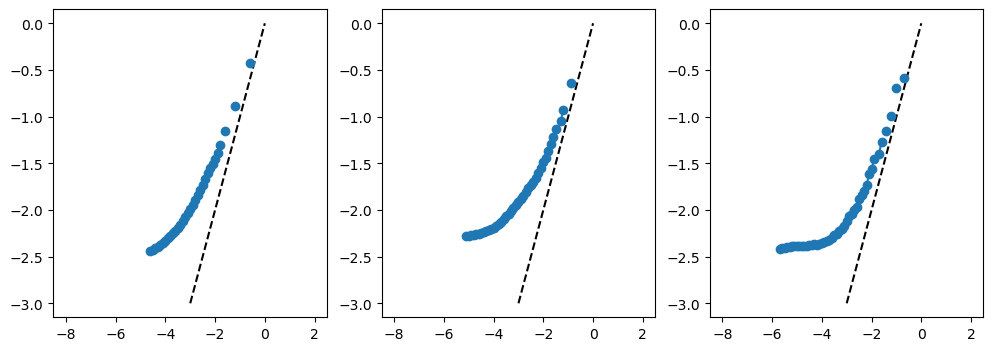

In [99]:
plt.figure(figsize=(12, 4))

learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)
num_epochs = 501

MLP_regressor_scratch.apply(init_weights)
MLP_regressor_scratch.float()

train_loss_traj, test_loss_traj = train_regressor(MLP_regressor_scratch, train_embedding_loader, test_embedding_loader, criterion, num_epochs)

log_bins = np.linspace(-8, 2, 101)

loss_dict = []
for _ in range(len(log_bins)):
    loss_dict.append([])

for train_loss, test_loss in zip(train_loss_traj, test_loss_traj):
    log_train = np.log(train_loss)
    log_test = np.log(test_loss)
    loss_key = (log_train + 8) / 0.1
    if loss_key - int(loss_key) > 0.5:
        loss_key = int(loss_key) + 1
    else:
        loss_key = int(loss_key) 

    loss_key = min(loss_key, len(log_bins)-1)
    loss_key = max(loss_key, 0)

    loss_dict[loss_key].append(log_test)
    
ave_loss = []
std_loss = []
std_error = []
lower_error = []
upper_error = []
for item in loss_dict:
    if len(item) > 0:
        ave_loss.append(np.mean(item))
        #max_dev = [np.mean(item)-min(item), max(item)-np.mean(item)]
        lower_error.append(np.mean(item)-min(item))
        upper_error.append(max(item)-np.mean(item))
        #std_loss.append(max_dev)
        std_loss.append(np.std(item))
        std_error.append(np.std(item) / np.sqrt(len(item)))
        #print(len(item), np.std(item))
    else:
        ave_loss.append(np.nan)
        std_loss.append(np.nan)
        lower_error.append(np.nan)
        upper_error.append(np.nan)
        std_error.append(np.nan)

plt.subplot(1, 3, 1)
plt.plot([-3, 0], [-3, 0], 'k--')
bound_loss = [lower_error, upper_error]
plt.errorbar(log_bins, ave_loss, yerr=std_loss, capsize=2, capthick=1, marker='o', label='SGD')\



learning_rate = 5e-3
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)
num_epochs = 501

MLP_regressor_scratch.apply(init_weights)
MLP_regressor_scratch.float()

train_loss_traj, test_loss_traj = train_regressor(MLP_regressor_scratch, train_embedding_loader, test_embedding_loader, criterion, num_epochs)

log_bins = np.linspace(-8, 2, 101)

loss_dict = []
for _ in range(len(log_bins)):
    loss_dict.append([])

for train_loss, test_loss in zip(train_loss_traj, test_loss_traj):
    log_train = np.log(train_loss)
    log_test = np.log(test_loss)
    loss_key = (log_train + 8) / 0.1
    if loss_key - int(loss_key) > 0.5:
        loss_key = int(loss_key) + 1
    else:
        loss_key = int(loss_key) 

    loss_key = min(loss_key, len(log_bins)-1)
    loss_key = max(loss_key, 0)

    loss_dict[loss_key].append(log_test)
    
ave_loss = []
std_loss = []
std_error = []
lower_error = []
upper_error = []
for item in loss_dict:
    if len(item) > 0:
        ave_loss.append(np.mean(item))
        #max_dev = [np.mean(item)-min(item), max(item)-np.mean(item)]
        lower_error.append(np.mean(item)-min(item))
        upper_error.append(max(item)-np.mean(item))
        #std_loss.append(max_dev)
        std_loss.append(np.std(item))
        std_error.append(np.std(item) / np.sqrt(len(item)))
        #print(len(item), np.std(item))
    else:
        ave_loss.append(np.nan)
        std_loss.append(np.nan)
        lower_error.append(np.nan)
        upper_error.append(np.nan)
        std_error.append(np.nan)

plt.subplot(1, 3, 2)
plt.plot([-3, 0], [-3, 0], 'k--')
bound_loss = [lower_error, upper_error]
plt.errorbar(log_bins, ave_loss, yerr=std_loss, capsize=2, capthick=1, marker='o', label='SGD')



learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)
num_epochs = 501

MLP_regressor_scratch.apply(init_weights)
MLP_regressor_scratch.float()

train_loss_traj, test_loss_traj = train_regressor(MLP_regressor_scratch, train_embedding_loader, test_embedding_loader, criterion, num_epochs)

log_bins = np.linspace(-8, 2, 101)

loss_dict = []
for _ in range(len(log_bins)):
    loss_dict.append([])

for train_loss, test_loss in zip(train_loss_traj, test_loss_traj):
    log_train = np.log(train_loss)
    log_test = np.log(test_loss)
    loss_key = (log_train + 8) / 0.1
    if loss_key - int(loss_key) > 0.5:
        loss_key = int(loss_key) + 1
    else:
        loss_key = int(loss_key) 

    loss_key = min(loss_key, len(log_bins)-1)
    loss_key = max(loss_key, 0)

    loss_dict[loss_key].append(log_test)
    
ave_loss = []
std_loss = []
std_error = []
lower_error = []
upper_error = []
for item in loss_dict:
    if len(item) > 0:
        ave_loss.append(np.mean(item))
        #max_dev = [np.mean(item)-min(item), max(item)-np.mean(item)]
        lower_error.append(np.mean(item)-min(item))
        upper_error.append(max(item)-np.mean(item))
        #std_loss.append(max_dev)
        std_loss.append(np.std(item))
        std_error.append(np.std(item) / np.sqrt(len(item)))
        #print(len(item), np.std(item))
    else:
        ave_loss.append(np.nan)
        std_loss.append(np.nan)
        lower_error.append(np.nan)
        upper_error.append(np.nan)
        std_error.append(np.nan)

plt.subplot(1, 3, 3)
plt.plot([-3, 0], [-3, 0], 'k--')
bound_loss = [lower_error, upper_error]
plt.errorbar(log_bins, ave_loss, yerr=std_loss, capsize=2, capthick=1, marker='o', label='SGD')

In [18]:
%%time

# mixed lr

width = 2

all_train_loss = []
all_test_loss = []
criterion = nn.MSELoss()
num_epochs = 501

for t in range(40):
    if t < 20:
        learning_rate = 1e-2
    else:
        learning_rate = 1e-2
        
    print(f'Step {t}, lr {learning_rate}')
    MLP_regressor_scratch = nn.Sequential(nn.Linear(768, width), nn.SiLU(), nn.Linear(width, 1))
    MLP_regressor_scratch.apply(init_weights)
    MLP_regressor_scratch.float()
    optimizer = torch.optim.SGD(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)
    #optimizer = torch.optim.Adam(MLP_regressor_scratch.parameters(), lr=learning_rate, weight_decay=0e-3)

    train_loss_traj, test_loss_traj = train_regressor(MLP_regressor_scratch, train_embedding_loader, test_embedding_loader, criterion, num_epochs)
    all_train_loss = all_train_loss + train_loss_traj
    all_test_loss = all_test_loss + test_loss_traj

Step 0, lr 0.01
Epoch 1: Train loss is 0.1939, test loss is 0.3053
        : Task1 train R2 is 0.8061, Task1 test R2 is 0.7388
Epoch 101: Train loss is 0.0087, test loss is 0.0848
        : Task1 train R2 is 0.9913, Task1 test R2 is 0.9274
Epoch 201: Train loss is 0.0061, test loss is 0.0824
        : Task1 train R2 is 0.9939, Task1 test R2 is 0.9295
Epoch 301: Train loss is 0.0049, test loss is 0.0794
        : Task1 train R2 is 0.9951, Task1 test R2 is 0.9320
Epoch 401: Train loss is 0.0042, test loss is 0.0777
        : Task1 train R2 is 0.9958, Task1 test R2 is 0.9335
Epoch 501: Train loss is 0.0037, test loss is 0.0772
        : Task1 train R2 is 0.9963, Task1 test R2 is 0.9340
Step 1, lr 0.01
Epoch 1: Train loss is 0.3991, test loss is 0.4443
        : Task1 train R2 is 0.6009, Task1 test R2 is 0.6199
Epoch 101: Train loss is 0.0111, test loss is 0.1012
        : Task1 train R2 is 0.9889, Task1 test R2 is 0.9134
Epoch 201: Train loss is 0.0072, test loss is 0.0950
        : Task1

Epoch 501: Train loss is 0.0030, test loss is 0.0815
        : Task1 train R2 is 0.9970, Task1 test R2 is 0.9302
Step 12, lr 0.01
Epoch 1: Train loss is 0.4568, test loss is 0.5122
        : Task1 train R2 is 0.5432, Task1 test R2 is 0.5617
Epoch 101: Train loss is 0.0107, test loss is 0.0995
        : Task1 train R2 is 0.9893, Task1 test R2 is 0.9149
Epoch 201: Train loss is 0.0070, test loss is 0.0951
        : Task1 train R2 is 0.9930, Task1 test R2 is 0.9186
Epoch 301: Train loss is 0.0055, test loss is 0.0929
        : Task1 train R2 is 0.9945, Task1 test R2 is 0.9205
Epoch 401: Train loss is 0.0043, test loss is 0.0935
        : Task1 train R2 is 0.9957, Task1 test R2 is 0.9200
Epoch 501: Train loss is 0.0039, test loss is 0.0926
        : Task1 train R2 is 0.9961, Task1 test R2 is 0.9208
Step 13, lr 0.01
Epoch 1: Train loss is 0.7891, test loss is 0.7800
        : Task1 train R2 is 0.2109, Task1 test R2 is 0.3326
Epoch 101: Train loss is 0.2667, test loss is 0.4276
        : Tas

Epoch 401: Train loss is 0.0044, test loss is 0.0903
        : Task1 train R2 is 0.9956, Task1 test R2 is 0.9227
Epoch 501: Train loss is 0.0034, test loss is 0.0904
        : Task1 train R2 is 0.9966, Task1 test R2 is 0.9227
Step 24, lr 0.01
Epoch 1: Train loss is 0.5406, test loss is 0.7520
        : Task1 train R2 is 0.4594, Task1 test R2 is 0.3565
Epoch 101: Train loss is 0.0182, test loss is 0.1045
        : Task1 train R2 is 0.9818, Task1 test R2 is 0.9106
Epoch 201: Train loss is 0.0099, test loss is 0.1025
        : Task1 train R2 is 0.9901, Task1 test R2 is 0.9123
Epoch 301: Train loss is 0.0072, test loss is 0.1010
        : Task1 train R2 is 0.9928, Task1 test R2 is 0.9135
Epoch 401: Train loss is 0.0056, test loss is 0.1002
        : Task1 train R2 is 0.9944, Task1 test R2 is 0.9143
Epoch 501: Train loss is 0.0049, test loss is 0.1013
        : Task1 train R2 is 0.9951, Task1 test R2 is 0.9133
Step 25, lr 0.01
Epoch 1: Train loss is 0.8785, test loss is 1.0261
        : Tas

Epoch 301: Train loss is 0.0034, test loss is 0.0970
        : Task1 train R2 is 0.9966, Task1 test R2 is 0.9170
Epoch 401: Train loss is 0.0028, test loss is 0.0956
        : Task1 train R2 is 0.9972, Task1 test R2 is 0.9182
Epoch 501: Train loss is 0.0026, test loss is 0.0964
        : Task1 train R2 is 0.9974, Task1 test R2 is 0.9175
Step 36, lr 0.01
Epoch 1: Train loss is 0.2290, test loss is 0.2935
        : Task1 train R2 is 0.7710, Task1 test R2 is 0.7489
Epoch 101: Train loss is 0.0104, test loss is 0.1046
        : Task1 train R2 is 0.9896, Task1 test R2 is 0.9105
Epoch 201: Train loss is 0.0068, test loss is 0.1001
        : Task1 train R2 is 0.9932, Task1 test R2 is 0.9143
Epoch 301: Train loss is 0.0043, test loss is 0.1009
        : Task1 train R2 is 0.9957, Task1 test R2 is 0.9137
Epoch 401: Train loss is 0.0035, test loss is 0.0990
        : Task1 train R2 is 0.9965, Task1 test R2 is 0.9153
Epoch 501: Train loss is 0.0029, test loss is 0.1005
        : Task1 train R2 is 

In [19]:
with open('./general training loss summary/W2/SGD_train_loss_traj.pickle', 'wb') as pickle_file:
    pickle.dump(all_train_loss, pickle_file)
    
with open('./general training loss summary/W2/SGD_test_loss_traj.pickle', 'wb') as pickle_file:
    pickle.dump(all_test_loss, pickle_file)

CPU times: user 80.1 ms, sys: 6.98 ms, total: 87.1 ms
Wall time: 87 ms


<ErrorbarContainer object of 3 artists>

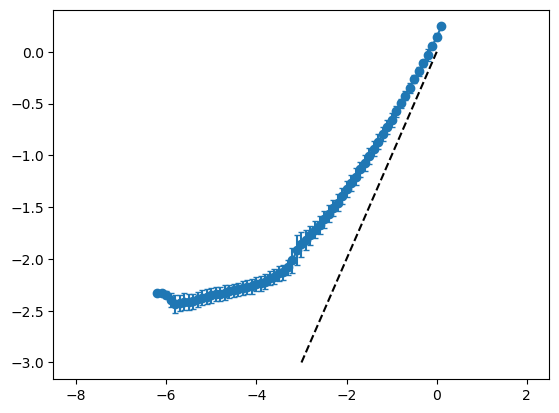

In [20]:
%%time
log_bins = np.linspace(-8, 2, 101)

loss_dict = []
for _ in range(len(log_bins)):
    loss_dict.append([])

for train_loss, test_loss in zip(all_train_loss, all_test_loss):
    log_train = np.log(train_loss)
    log_test = np.log(test_loss)
    loss_key = (log_train + 8) / 0.1
    if loss_key - int(loss_key) > 0.5:
        loss_key = int(loss_key) + 1
    else:
        loss_key = int(loss_key) 

    loss_key = min(loss_key, len(log_bins)-1)
    loss_key = max(loss_key, 0)

    loss_dict[loss_key].append(log_test)
    
ave_loss = []
std_loss = []
std_error = []
lower_error = []
upper_error = []
for item in loss_dict:
    if len(item) > 0:
        ave_loss.append(np.mean(item))
        #max_dev = [np.mean(item)-min(item), max(item)-np.mean(item)]
        lower_error.append(np.mean(item)-min(item))
        upper_error.append(max(item)-np.mean(item))
        #std_loss.append(max_dev)
        std_loss.append(np.std(item))
        std_error.append(np.std(item) / np.sqrt(len(item)))
        #print(len(item), np.std(item))
    else:
        ave_loss.append(np.nan)
        std_loss.append(np.nan)
        lower_error.append(np.nan)
        upper_error.append(np.nan)
        std_error.append(np.nan)
        
plt.plot([-3, 0], [-3, 0], 'k--')
bound_loss = [lower_error, upper_error]
plt.errorbar(log_bins, ave_loss, yerr=std_loss, capsize=2, capthick=1, marker='o', label='SGD')

Text(0.5, 1.0, 'L1N2_batch32_loss_std_error')

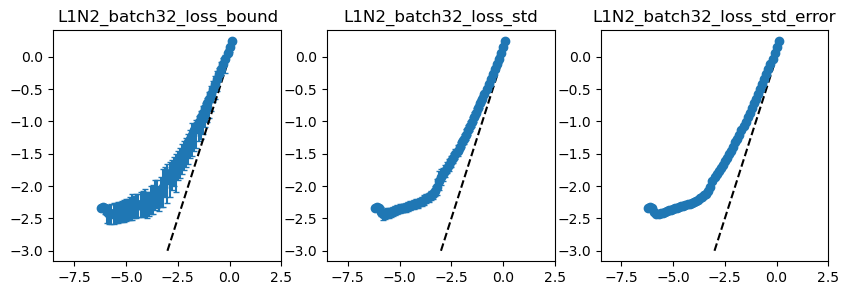

In [21]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.errorbar(log_bins, ave_loss, yerr=bound_loss, capsize=2, capthick=1, marker='o', label='SGD_128')
plt.plot([-3, 0], [-3, 0], 'k--')
plt.title('L1N2_batch32_loss_bound')

plt.subplot(1, 3, 2)
plt.errorbar(log_bins, ave_loss, yerr=std_loss, capsize=2, capthick=1, marker='o', label='SGD_128')
plt.plot([-3, 0], [-3, 0], 'k--')
plt.title('L1N2_batch32_loss_std')

plt.subplot(1, 3, 3)
plt.errorbar(log_bins, ave_loss, yerr=std_error, capsize=2, capthick=1, marker='o', label='SGD_128')
plt.plot([-3, 0], [-3, 0], 'k--')
plt.title('L1N2_batch32_loss_std_error')

In [22]:
general_train_loss_summary = np.vstack([log_bins, ave_loss, lower_error, upper_error, std_loss, std_error]).T
general_train_loss_summary.shape

np.savetxt('./general training loss summary/L1N2_SGD32_loss_summary.txt', general_train_loss_summary)